In [50]:
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Предсказание погоды на следующий день: 
Будет дождь, если rainfall >=1

In [51]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [52]:
df.shape

(145460, 23)

Удалим столбцы

In [53]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

Удаление строк с пропущенными значениями

In [54]:
df = df.dropna()
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No


Преобразование данных стобца

In [55]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

/var/folders/z2/889mcdgx68s4l2p7x5f310hm0000gn/T/ipykernel_44481/3680518046.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
/var/folders/z2/889mcdgx68s4l2p7x5f310hm0000gn/T/ipykernel_44481/3680518046.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downca

In [56]:
df[df['RainTomorrow']==0.0].count()

Rainfall        97103
Humidity3pm     97103
Pressure9am     97103
RainToday       97103
RainTomorrow    97103
dtype: int64

In [57]:
df[df['RainTomorrow']==1.0].count()

Rainfall        27586
Humidity3pm     27586
Pressure9am     27586
RainToday       27586
RainTomorrow    27586
dtype: int64

Классы несбалансированы

In [58]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Преобразуем в тензор

In [59]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


#NN

In [60]:

class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 8)
    self.fc2 = nn.Linear(8, 4)
    self.fc3 = nn.Linear(4, 1)
    
    # torch.nn.init.xavier_uniform_(self.fc1.weight) 

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

In [61]:
criterion = nn.BCELoss()

In [62]:
device = torch.device( "cpu")

In [63]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [64]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [65]:
net = Net(4)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
net = net.to(device)

criterion = criterion.to(device)

for epoch in range(2000):

    train_loss = 0
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
        
    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    if epoch % 100 == 0:

          y_test_pred = net(X_test)
          y_test_pred = torch.squeeze(y_test_pred)

          test_loss = criterion(y_test_pred, y_test)

          test_acc = calculate_accuracy(y_test, y_test_pred)
          print(
    f'''epoch {epoch}
    Test  set - loss: {test_loss}, accuracy: {test_acc}
    ''')

epoch 0
    Test  set - loss: 7.164628505706787, accuracy: 0.2216697335243225
    
epoch 100
    Test  set - loss: 0.5720797777175903, accuracy: 0.796014130115509
    
epoch 200
    Test  set - loss: 0.5436040163040161, accuracy: 0.7788916230201721
    
epoch 300
    Test  set - loss: 0.5333546996116638, accuracy: 0.7793327569961548
    
epoch 400
    Test  set - loss: 0.5154787302017212, accuracy: 0.7796936631202698
    
epoch 500
    Test  set - loss: 0.48074424266815186, accuracy: 0.7794530391693115
    
epoch 600
    Test  set - loss: 0.46781405806541443, accuracy: 0.7808966040611267
    
epoch 700
    Test  set - loss: 0.45575186610221863, accuracy: 0.784826397895813
    
epoch 800
    Test  set - loss: 0.4444059133529663, accuracy: 0.7911219596862793
    
epoch 900
    Test  set - loss: 0.43360546231269836, accuracy: 0.7986606955528259
    
epoch 1000
    Test  set - loss: 0.4241654872894287, accuracy: 0.8104900121688843
    
epoch 1100
    Test  set - loss: 0.41714295744895935, 

In [66]:
MODEL_PATH = 'model.pth'

torch.save(net, MODEL_PATH)

In [67]:
net = torch.load(MODEL_PATH)

/var/folders/z2/889mcdgx68s4l2p7x5f310hm0000gn/T/ipykernel_44481/3250838313.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(MODEL_PATH)


In [68]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     19413
     Raining       0.74      0.40      0.52      5525

    accuracy                           0.84     24938
   macro avg       0.79      0.68      0.71     24938
weighted avg       0.82      0.84      0.82     24938



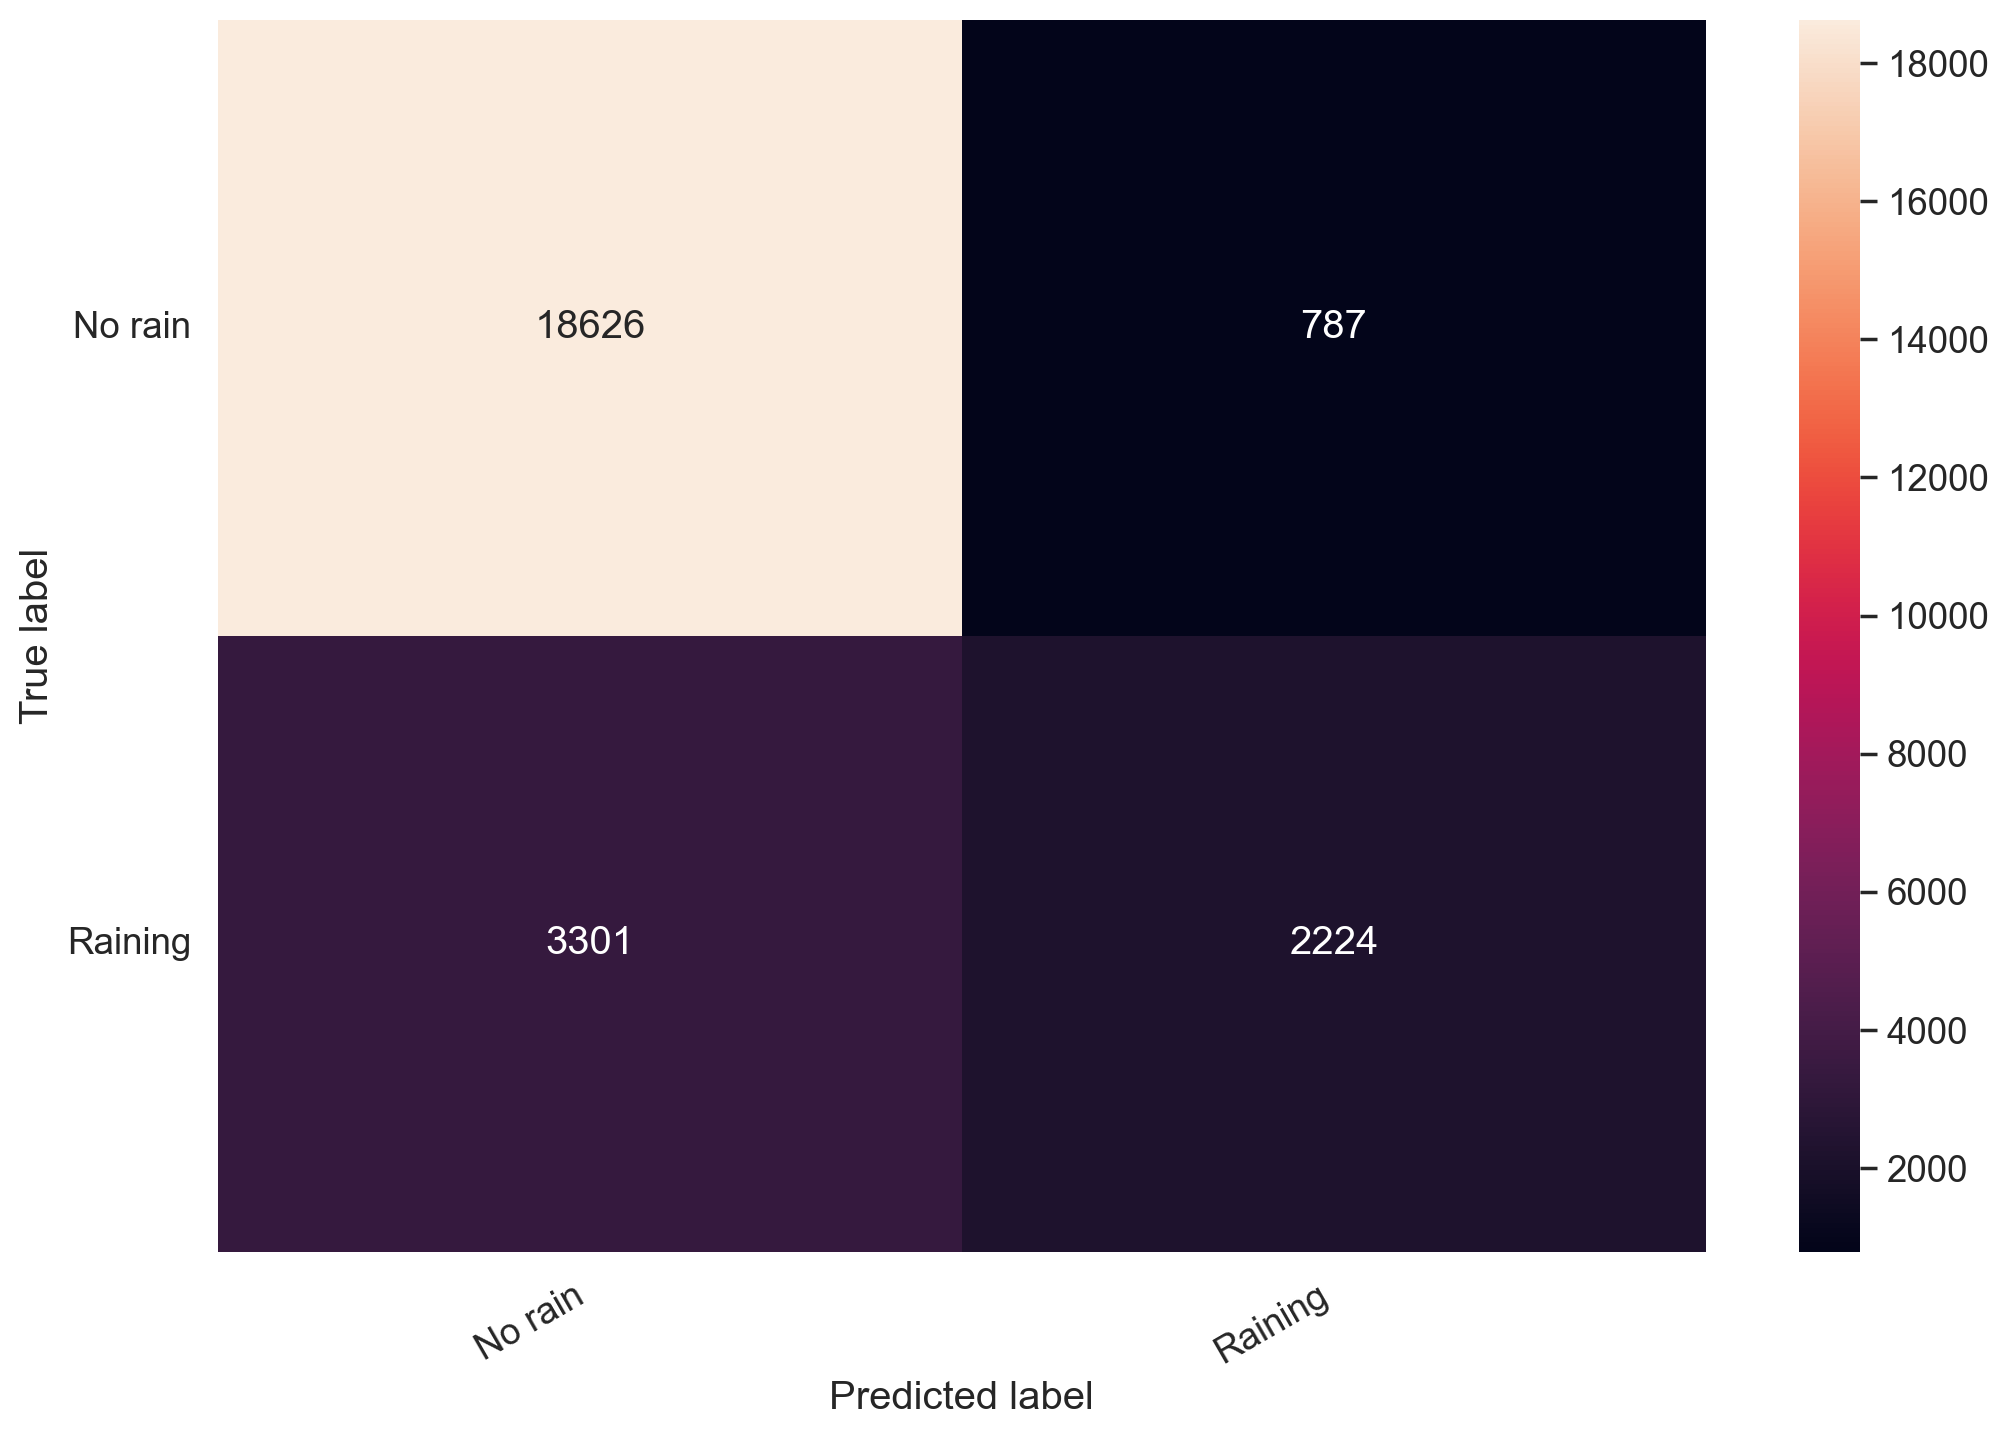

In [69]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [70]:
# 1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate, 
# выберите оптимальное значение.

# 2. Примените нормализацию данных. Исследуйте скорость сходимости.

# 3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления
# скрытого слоя, Удаления/добавления нейронов в каждом слое.

# 4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.
# https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

# 5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.
# https://pytorch.org/docs/stable/optim.html

# 6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.

In [71]:
# 1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate,
# выберите оптимальное значение.

In [72]:
# Разные значения learning_rate
learning_rates = [0.001, 0.01, 0.1]
losses = {}

In [73]:
criterion = nn.MSELoss()


In [74]:
for lr in learning_rates:
    net = Net(4)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    net = net.to(device)
    criterion = criterion.to(device)

    epoch_losses = []

    for epoch in range(200):
        y_pred = net(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_losses.append(train_loss.item())

    losses[lr] = epoch_losses

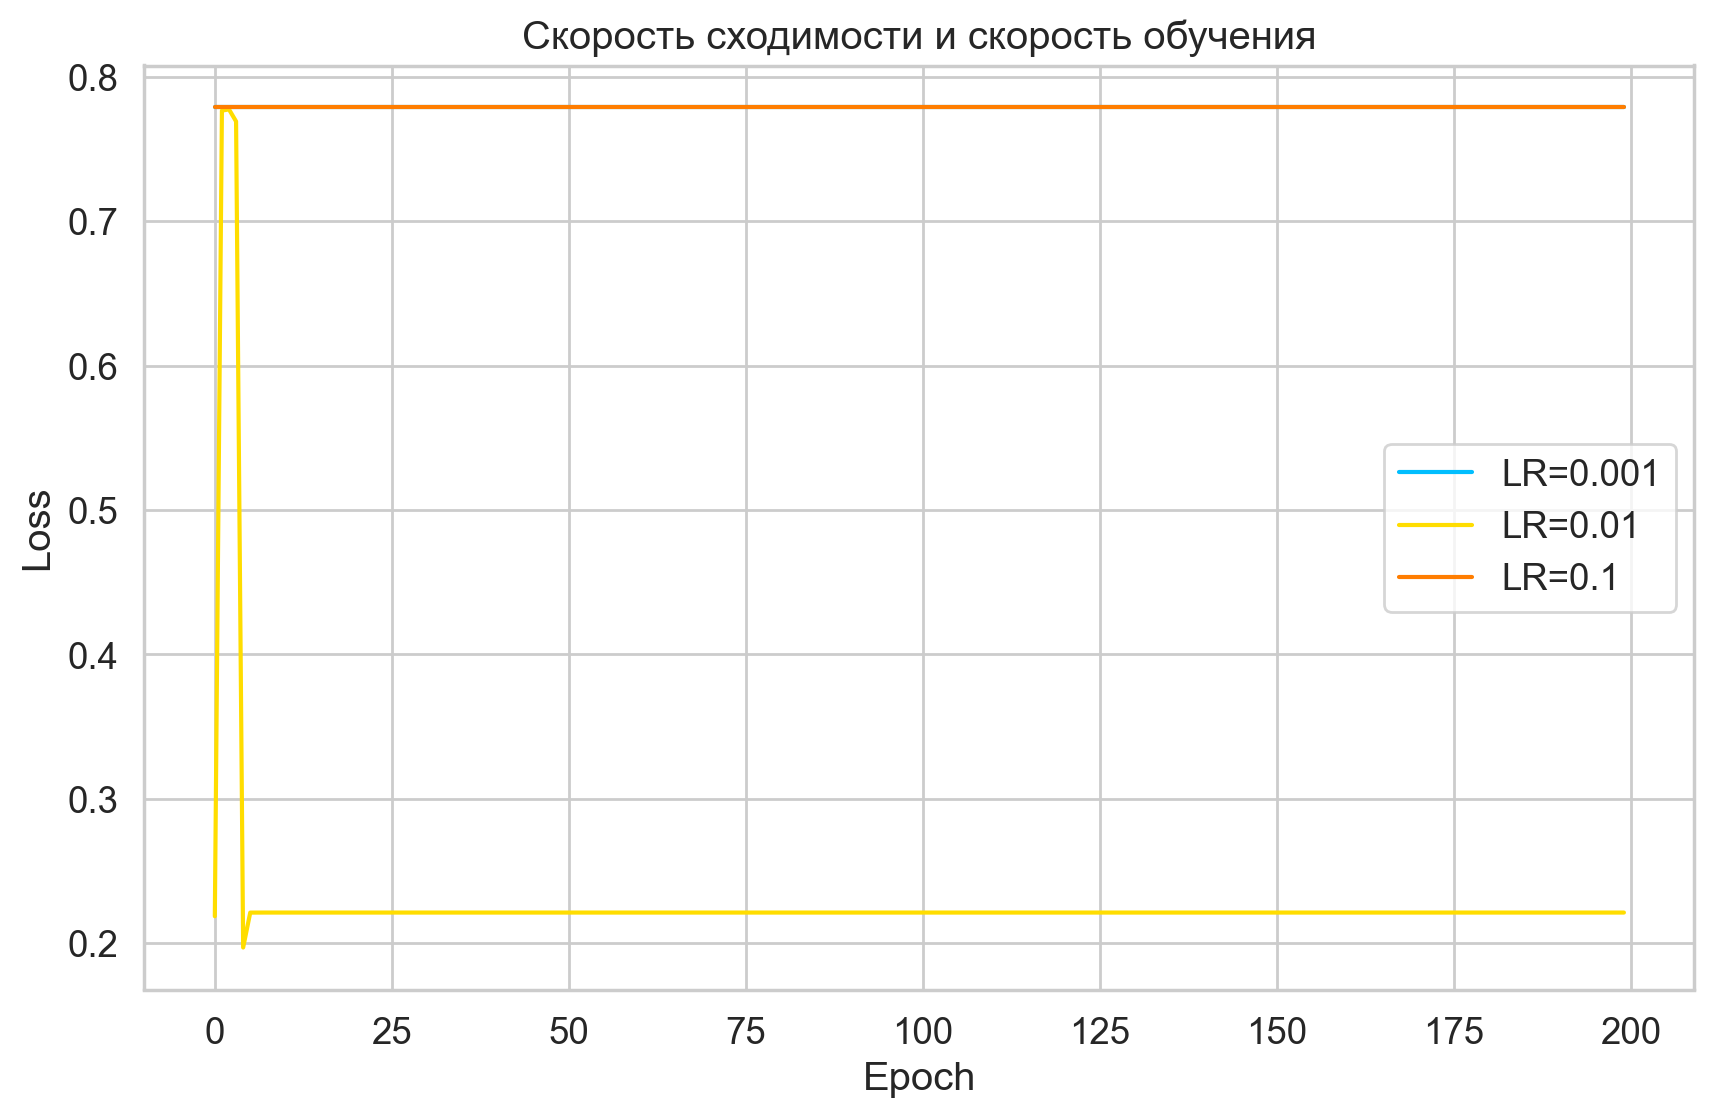

In [75]:
plt.figure(figsize=(10, 6))
for lr, loss in losses.items():
    plt.plot(loss, label=f'LR={lr}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Скорость сходимости и скорость обучения')
plt.legend()
plt.show()

In [76]:
# Находим оптимальное значение learning_rate
min_loss = float('inf')
optimal_lr = None

for lr, loss in losses.items():
    final_loss = loss[-1]  # Потеря на последней эпохе
    if final_loss < min_loss:
        min_loss = final_loss
        optimal_lr = lr

print(f'Оптимальное значение learning_rate: {optimal_lr} с потерей: {min_loss}')


Оптимальное значение learning_rate: 0.01 с потерей: 0.22116069495677948


In [77]:
from sklearn.preprocessing import StandardScaler

# Нормализация данных
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Преобразуем в тензоры после нормализации
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()

In [78]:
# Обучение модели с нормализованными данными
for lr in learning_rates:
    net = Net(4)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    net = net.to(device)
    criterion = criterion.to(device)

    epoch_losses = []

    for epoch in range(200):
        y_pred = net(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_losses.append(train_loss.item())

    losses[lr] = epoch_losses


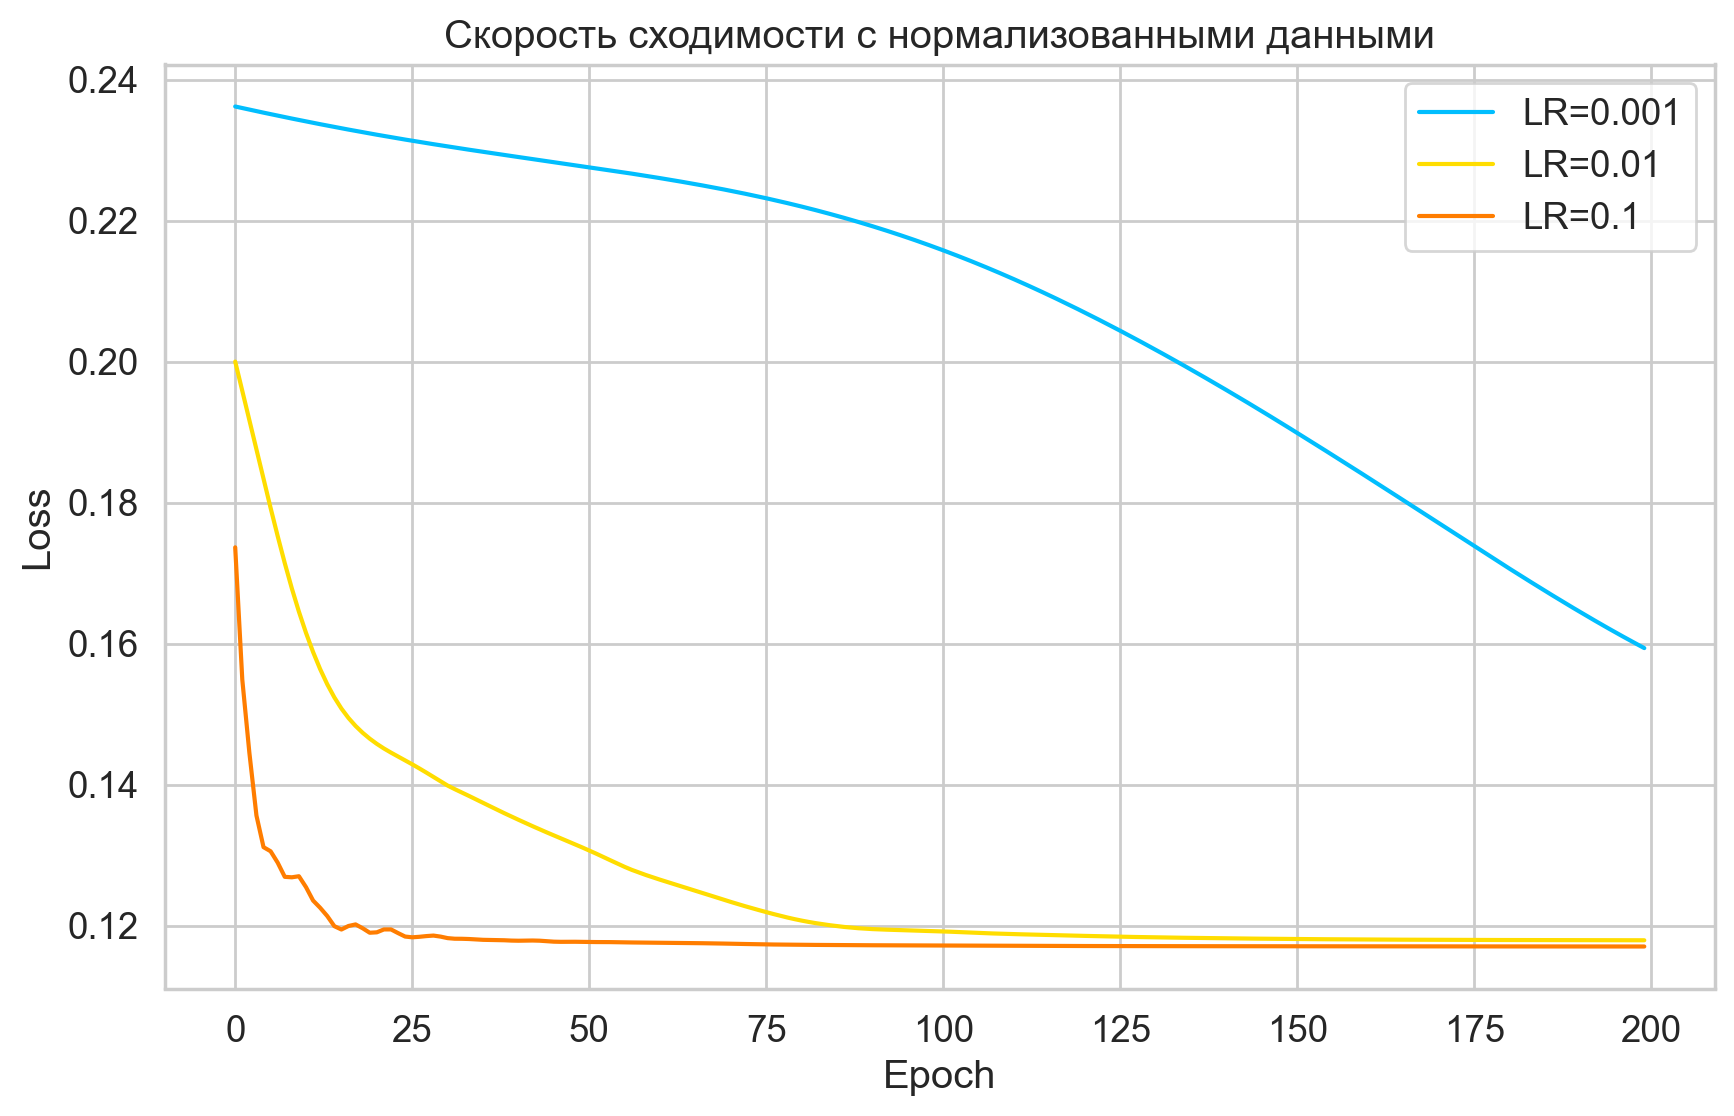

In [79]:
plt.figure(figsize=(10, 6))
for lr, loss in losses.items():
    plt.plot(loss, label=f'LR={lr}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Скорость сходимости с нормализованными данными')
plt.legend()
plt.show()

In [80]:
class NetVariant1(nn.Module):
    def __init__(self):
        super(NetVariant1, self).__init__()
        self.fc1 = nn.Linear(4, 8)  # Увеличено количество нейронов
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [81]:
class NetVariant2(nn.Module):
    def __init__(self):
        super(NetVariant2, self).__init__()
        self.fc1 = nn.Linear(4, 4)  # Оригинальное количество нейронов
        self.fc2 = nn.Linear(4, 4)  # Добавлен дополнительный скрытый слой
        self.fc3 = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [82]:
models = {
    "Original": Net(4),
    "More Neurons": NetVariant1(),
    "Extra Layer": NetVariant2()
}

results = {}

In [83]:
# Обучение и оценка каждой модели
for name, model in models.items():
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = criterion.to(device)

    epoch_losses = []

    for epoch in range(200):
        y_pred = model(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_losses.append(train_loss.item())

    results[name] = epoch_losses


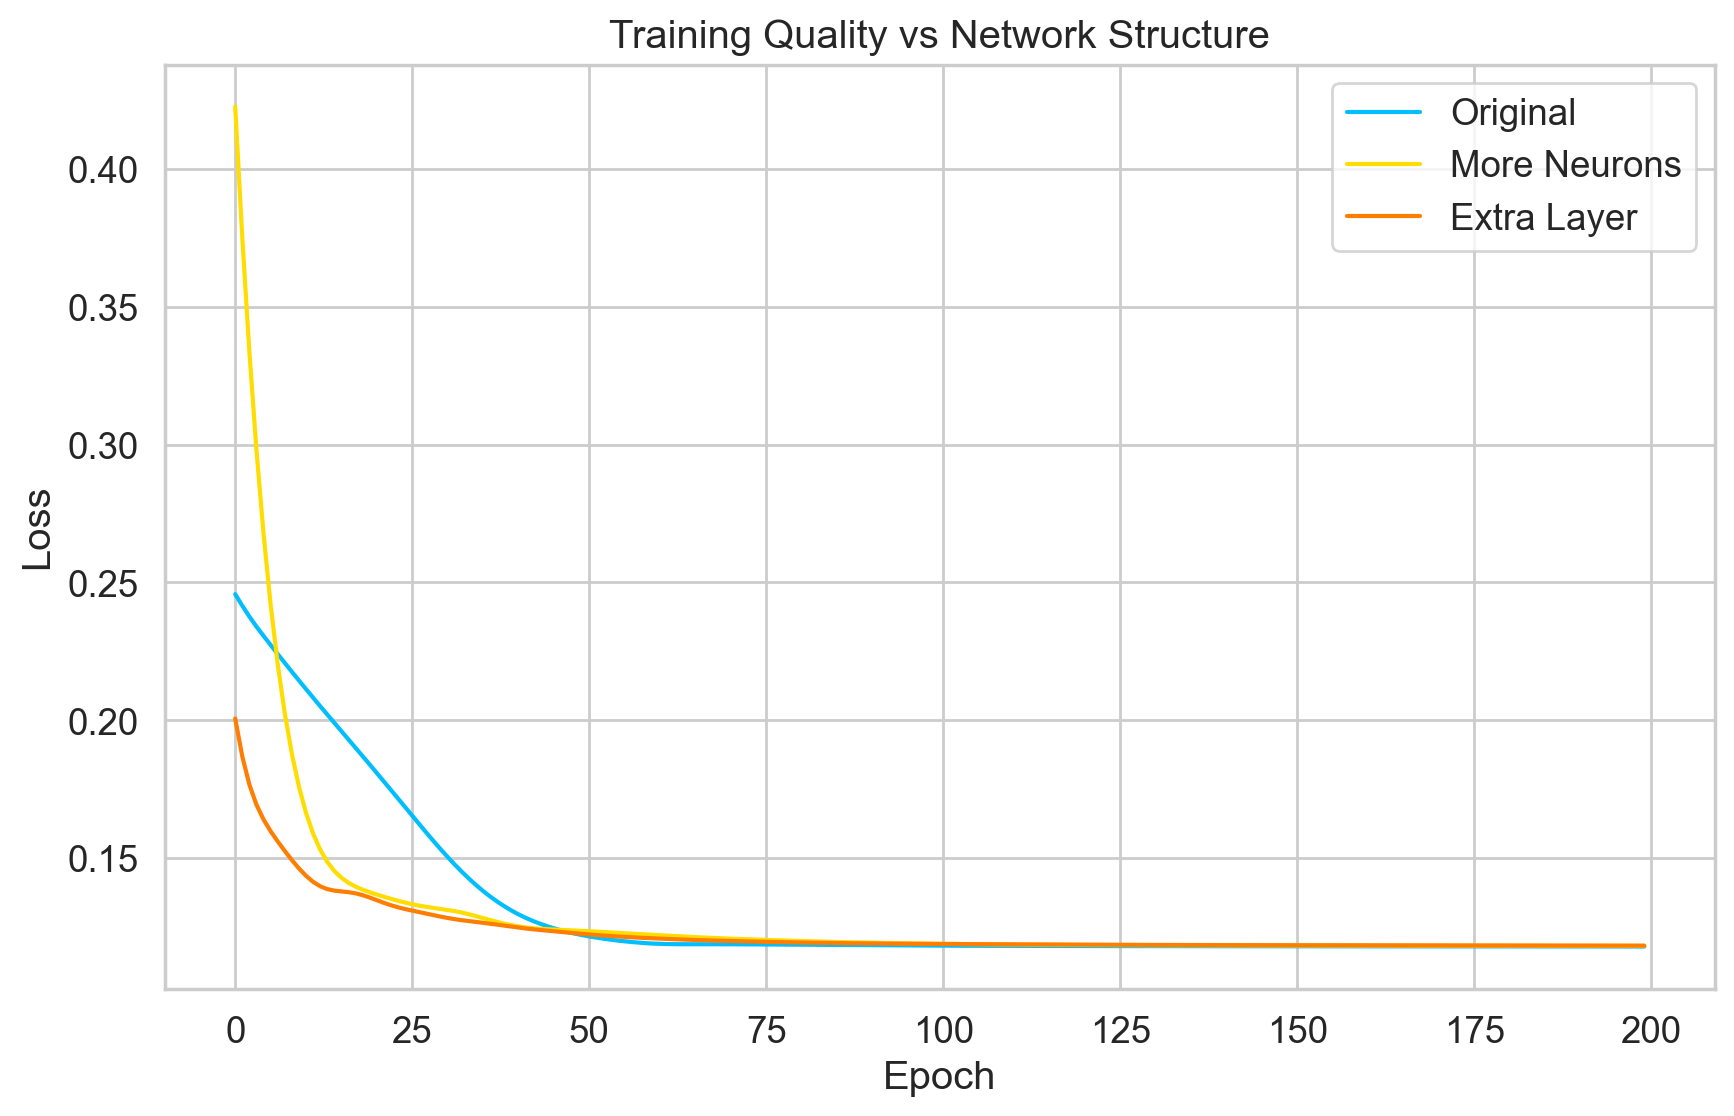

In [84]:
plt.figure(figsize=(10, 6))
for name, loss in results.items():
    plt.plot(loss, label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Quality vs Network Structure')
plt.legend()
plt.show()

In [85]:
import torch.nn.functional as F


In [86]:
class NetReLU(nn.Module):
    def __init__(self):
        super(NetReLU, self).__init__()
        self.fc1 = nn.Linear(4, 4)
        self.fc2 = nn.Linear(4, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [87]:
class NetSigmoid(nn.Module):
    def __init__(self):
        super(NetSigmoid, self).__init__()
        self.fc1 = nn.Linear(4, 4)
        self.fc2 = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x


In [88]:
class NetTanh(nn.Module):
    def __init__(self):
        super(NetTanh, self).__init__()
        self.fc1 = nn.Linear(4, 4)
        self.fc2 = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [89]:
activation_models = {
    "ReLU": NetReLU(),
    "Sigmoid": NetSigmoid(),
    "Tanh": NetTanh()
}

In [90]:
activation_results = {}

# Обучение и оценка каждой модели
for name, model in activation_models.items():
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = criterion.to(device)

    epoch_losses = []

    for epoch in range(200):
        y_pred = model(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_losses.append(train_loss.item())

    activation_results[name] = epoch_losses


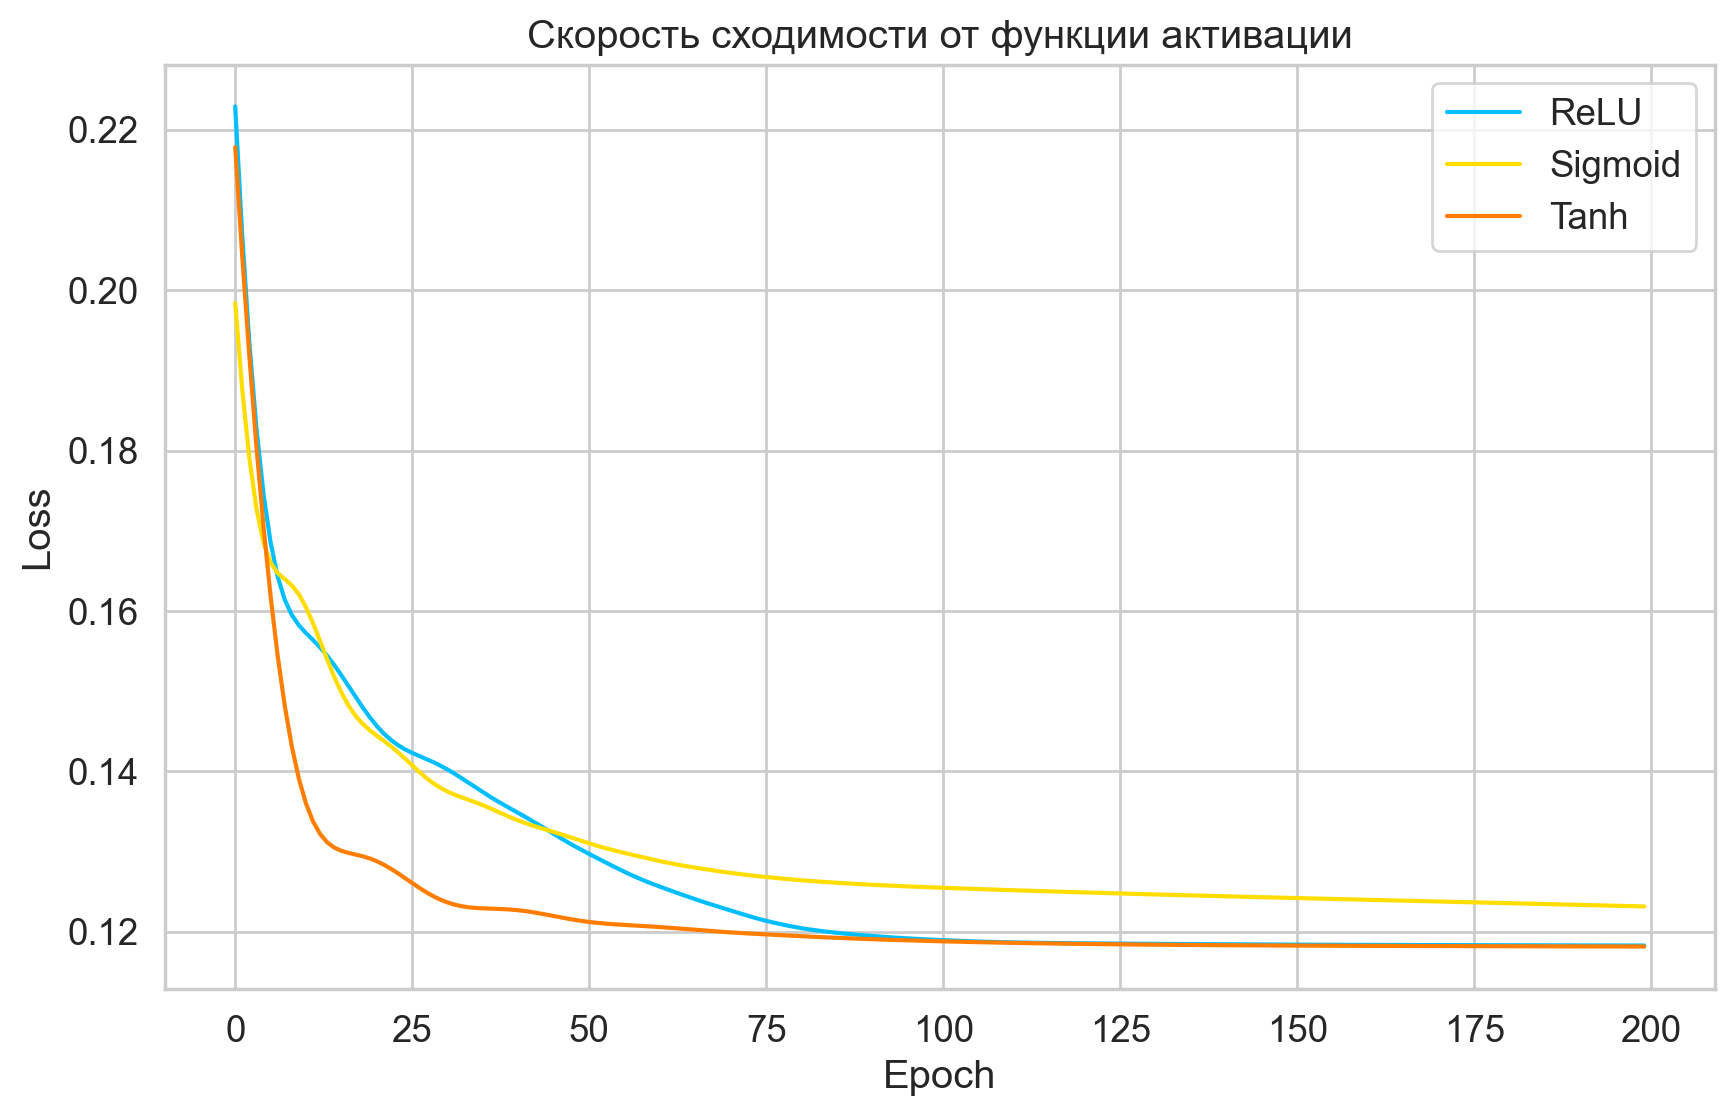

In [91]:
plt.figure(figsize=(10, 6))
for name, loss in activation_results.items():
    plt.plot(loss, label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Скорость сходимости от функции активации')
plt.legend()
plt.show()

In [92]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 4)
        self.fc2 = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [93]:
# Список оптимизаторов для тестирования
optimizers = {
    "SGD": lambda params: optim.SGD(params, lr=0.01),
    "Adam": lambda params: optim.Adam(params, lr=0.01),
    "RMSprop": lambda params: optim.RMSprop(params, lr=0.01)
}


In [94]:
optimizer_results = {}

# Обучение и оценка каждой модели с разными оптимизаторами
for name, optimizer_func in optimizers.items():
    model = Net().to(device)
    optimizer = optimizer_func(model.parameters())
    criterion = criterion.to(device)

    epoch_losses = []

    for epoch in range(200):
        y_pred = model(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_losses.append(train_loss.item())

    optimizer_results[name] = epoch_losses


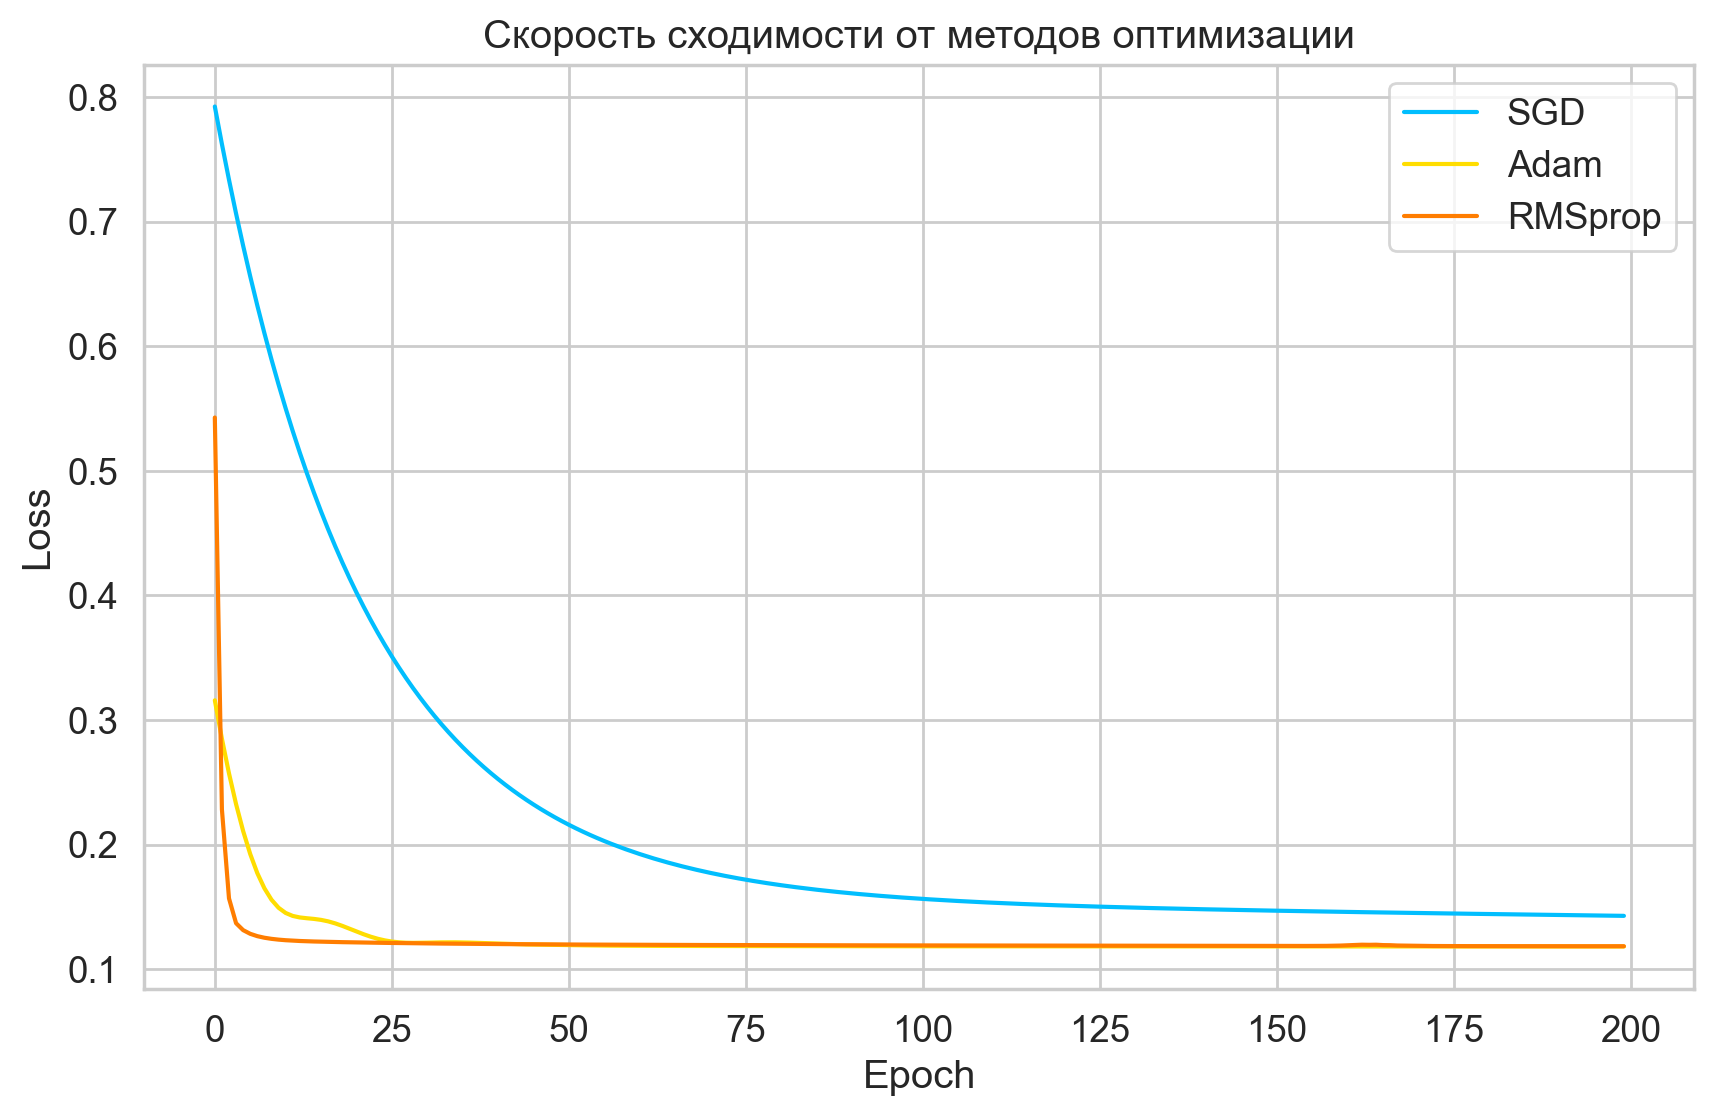

In [95]:
plt.figure(figsize=(10, 6))
for name, loss in optimizer_results.items():
    plt.plot(loss, label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Скорость сходимости от методов оптимизации')
plt.legend()
plt.show()

In [96]:
# Определение модели с возможностью инициализации весов
class Net(nn.Module):
    def __init__(self, init_func=None):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 4)
        self.fc2 = nn.Linear(4, 1)

        if init_func:
            self.apply(init_func)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [97]:
def init_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.1)
        nn.init.constant_(m.bias, 0)


In [98]:
def init_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)


In [99]:
def init_kaiming(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        nn.init.constant_(m.bias, 0)

In [100]:
initializations = {
    "Normal": init_normal,
    "Xavier": init_xavier,
    "Kaiming": init_kaiming
}

init_results = {}

In [101]:
for name, init_func in initializations.items():
    model = Net(init_func=init_func).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = criterion.to(device)

    epoch_losses = []

    for epoch in range(200):
        y_pred = model(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_losses.append(train_loss.item())

    init_results[name] = epoch_losses


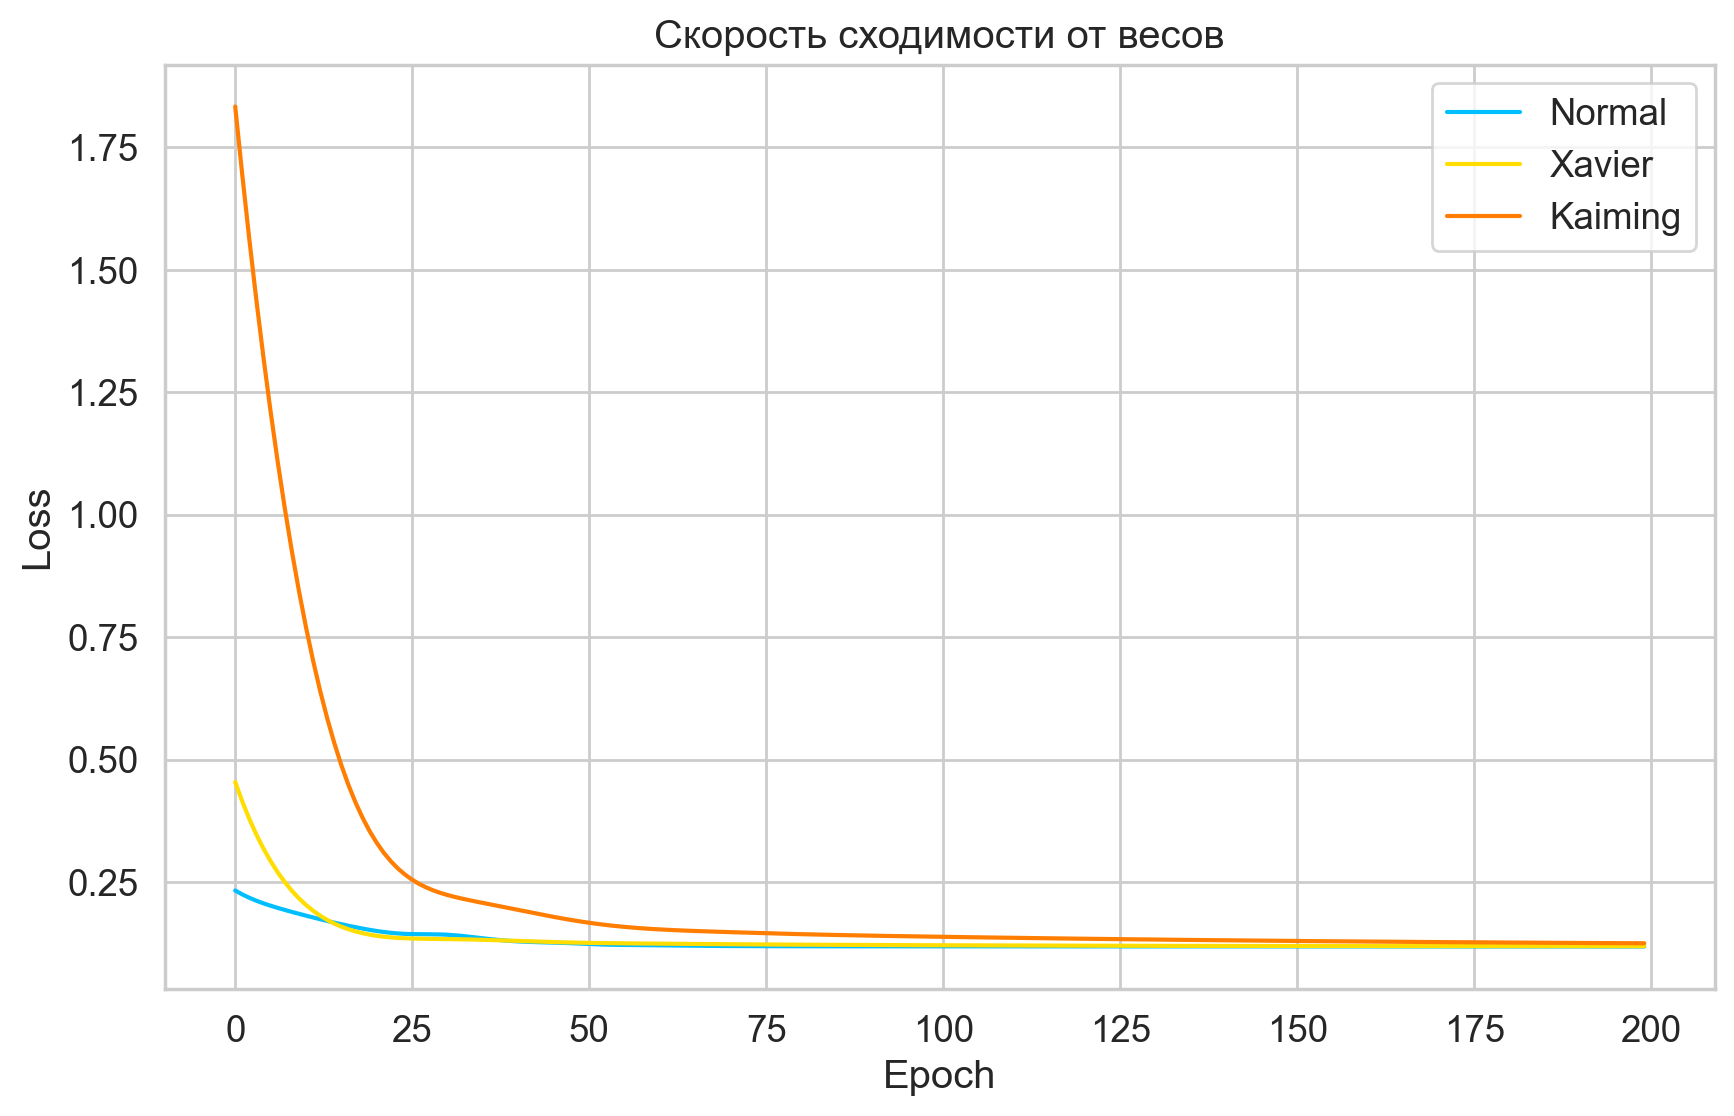

In [102]:
plt.figure(figsize=(10, 6))
for name, loss in init_results.items():
    plt.plot(loss, label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Скорость сходимости от весов')
plt.legend()
plt.show()